In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import io
import zipfile

from src.plot_with_coordinates import eea_to_wgs_points


pd.set_option('display.max_columns', 30)

def read_zip_df(zip_path: str | Path, sep: str = "\t") -> pd.DataFrame:
    zip_path = Path(zip_path)
    with zipfile.ZipFile(zip_path) as zf:
        name = zf.namelist()[0]
        with zf.open(name) as fh:
            df = pd.read_csv(io.TextIOWrapper(fh, encoding="utf-8"), sep=sep)
    return df


In [ ]:
TARGET_RES = 0.25 #degres
LON_MIN, LON_MAX = -30, 50
LAT_MIN, LAT_MAX = 34, 72

# df_pts = output of eea_to_wgs_points()
def upsample_to_025(df_pts: pd.DataFrame) -> pd.DataFrame:
    """Aggregate 0.1° WGS points to 0.25° grid."""
    df = df_pts.copy()
    # snap every point to centre of its 0.25° cell
    df["lon025"] = (np.floor(df["lon"] / TARGET_RES) * TARGET_RES) + TARGET_RES / 2
    df["lat025"] = (np.floor(df["lat"] / TARGET_RES) * TARGET_RES) + TARGET_RES / 2
    # clip to requested window
    df = df[df["lon025"].between(LON_MIN + TARGET_RES/2, LON_MAX) &
            df["lat025"].between(LAT_MIN + TARGET_RES/2, LAT_MAX)]
    # aggregate
    g = (df.groupby(["specieskey", "year", "month", "lon025", "lat025"], as_index=False)
           ["occurrences"].sum()
           .rename(columns={"lon025": "lon", "lat025": "lat", "occurrences": "n"}))
    # full rectangular grid for plotting or rasters
    lon_bins = np.arange(LON_MIN + TARGET_RES/2, LON_MAX + 1e-6, TARGET_RES)
    lat_bins = np.arange(LAT_MIN + TARGET_RES/2, LAT_MAX + 1e-6, TARGET_RES)
    grid = pd.MultiIndex.from_product(
        [g["specieskey"].unique(),
         g["year"].unique(),
         g["month"].unique(),
         lon_bins, lat_bins],
        names=["specieskey", "year", "month", "lon", "lat"]).to_frame(index=False)
    out = grid.merge(g, how="left", on=["specieskey", "year", "month", "lon", "lat"]).fillna({"n":0})
    return out

# --------------- comparison plot ---------------------------------------
def compare_resolutions(df_pts, df_025, species, year, month):
    fig, axes = plt.subplots(1,2, figsize=(20,10), sharex=False, sharey=False)
    # original 0.1°
    p = df_pts[(df_pts["specieskey"]==species)&(df_pts["year"]==year)&(df_pts["month"]==month)]
    sns.scatterplot(ax=axes[0], data=p, x="lon", y="lat",
                    hue="occurrences", size="occurrences",
                    palette="magma", legend=False, alpha=.6)
    axes[0].set_title("Original 0.1° points"); axes[0].set_aspect("equal","box")
    # new 0.25°
    q = df_025[(df_025["specieskey"]==species)&(df_025["year"]==year)&(df_025["month"]==month)]
    sns.scatterplot(ax=axes[1], data=q[q["n"]>0], x="lon", y="lat",
                    hue="n", size="n", palette="magma", legend=False, alpha=.8)
    axes[1].set_xlim(df_025["lon"].min()-0.25, df_025["lon"].max()+0.25)
    axes[1].set_ylim(df_025["lat"].min()-0.25, df_025["lat"].max()+0.25)    
    plt.tight_layout()
    return fig

⚠ Dropping 550 rows with empty eeacellcode


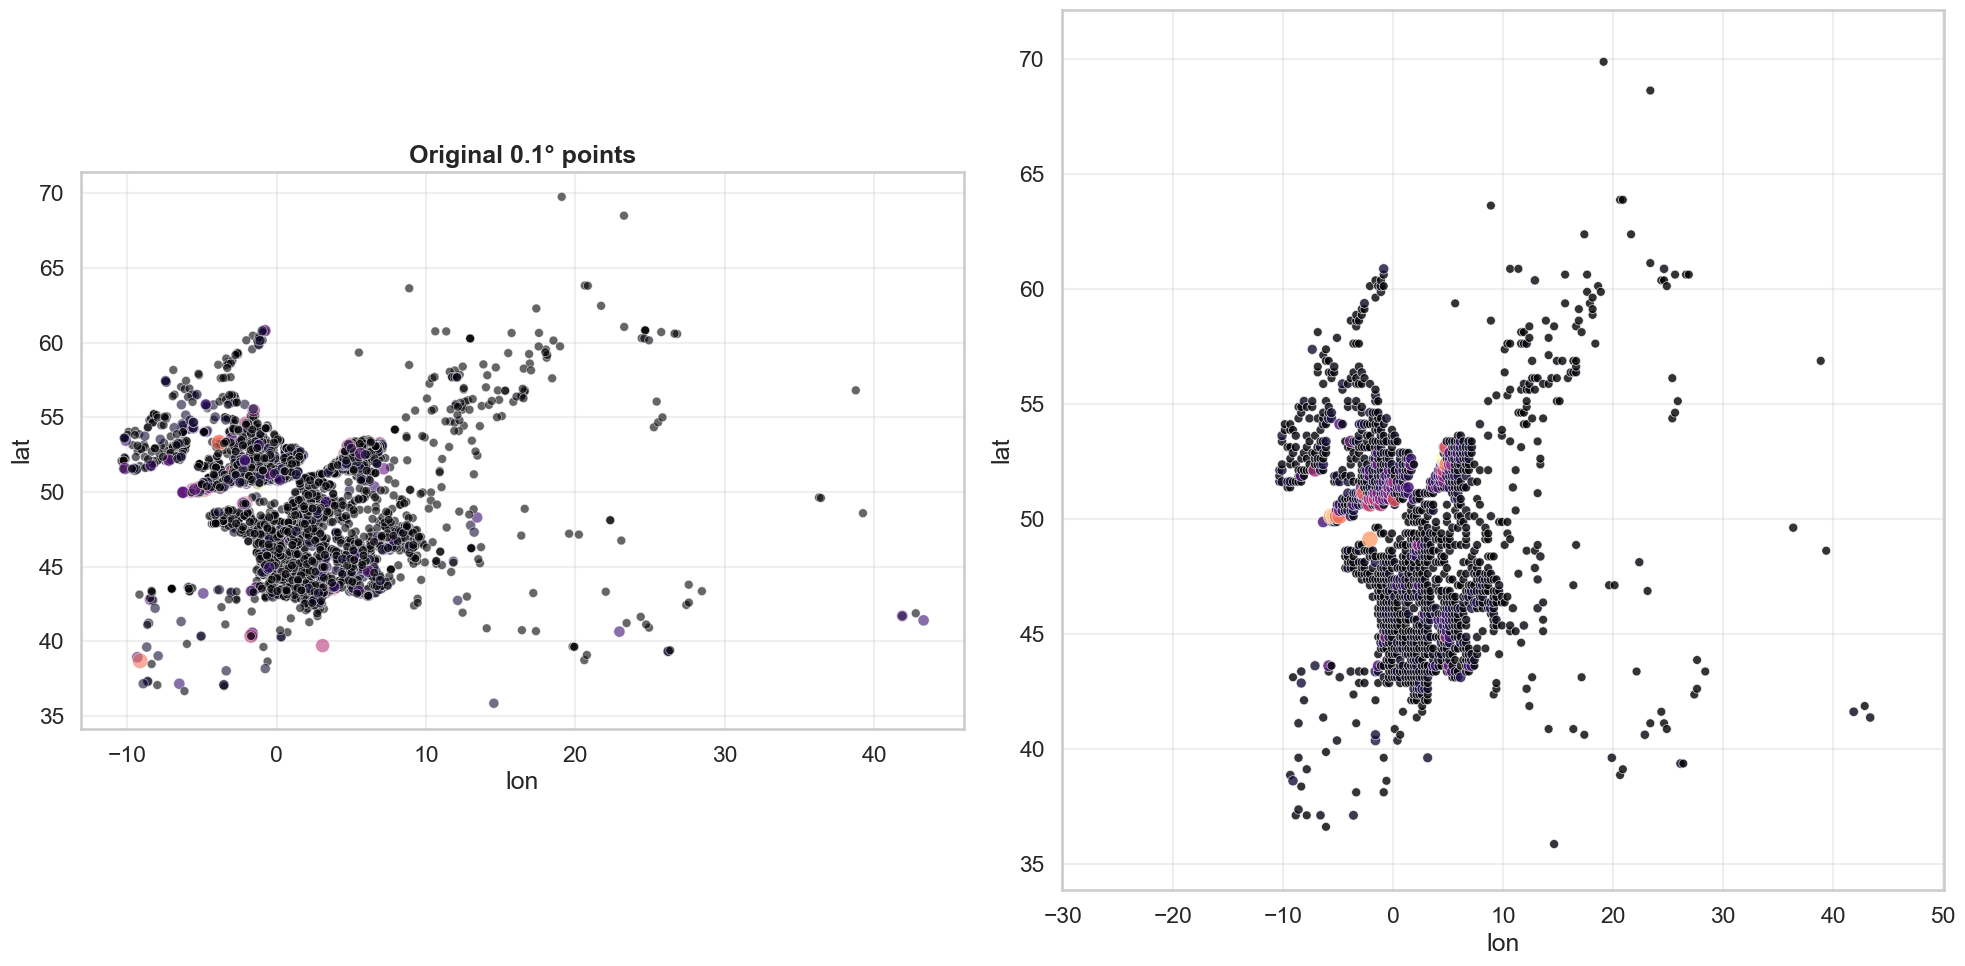

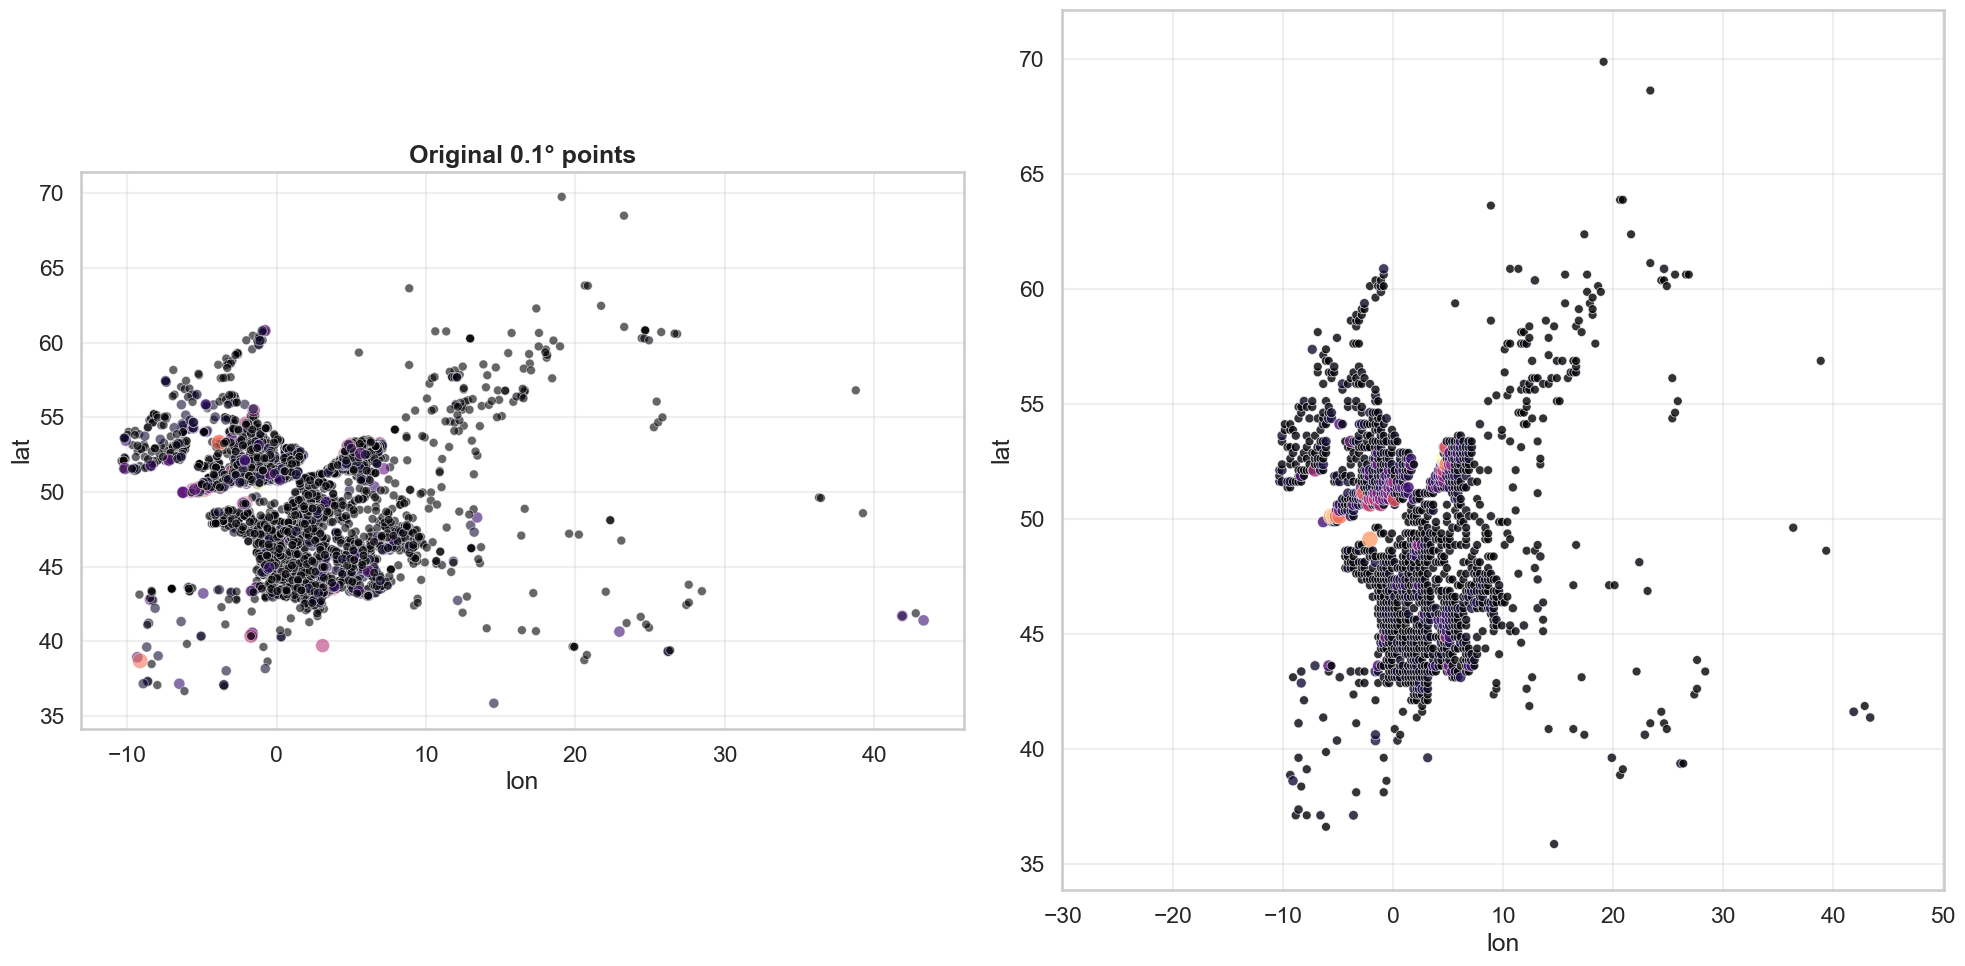

In [5]:
PATH = "gbif_manual/1898286.zip"
zip_path = Path(PATH)

df_raw = read_zip_df(zip_path)


df_pts = eea_to_wgs_points(df_raw)          # 0.1° centres
df_025  = upsample_to_025(df_pts)           # 0.25° grid

compare_resolutions(df_pts, df_025,
                    species=1898286, year=2019, month=5)

In [ ]:
df_025.tail(5)